In [1]:
# !pip install rdkit
# !pip install mendeleev

In [2]:
from collections import defaultdict
import copy
import math
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from mendeleev import isotope, element

In [294]:
# sml = "C=C=O"

# Create a molecule object
# sml = "CCO"  # Example molecule: Ethanol (C2H5OH)

# Add explicit hydrogens
# Chem.AddHs(mol)

# sml = "ClC(Cl)Cl"

# Carbon tetrachloride; four Cl
# sml = "ClC(Cl)(Cl)Cl"

# sml = "c1ccccc1" # benzene; boring

# Calcium carbonate; boring
# sml = "[Ca+2].[O-]C([O-])=O"

# Potassium cyanide; three elements
# sml = "[K+].[C-]#N"

# FeCl3; good for distinguishing very similar masses
# sml = "Cl[Fe](Cl)Cl"

# Cl2; simple case
sml = "ClCl"

# Homo triatomic
# sml = "[O-][O+]=O"

# Homo diatomic
# sml = "O=O"

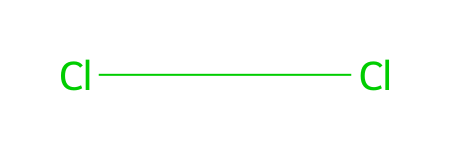

In [295]:
Chem.MolFromSmiles(sml)

In [296]:
mol = Chem.AddHs(Chem.MolFromSmiles(sml))
# print(composition(mol))
print(Chem.MolToSmiles(mol))
# mol_with_hydrogens = Chem.AddHs(mol)
# print(Chem.MolToSmiles(mol_with_hydrogens))
# print(composition(mol_with_hydrogens))
# same = composition(mol) == composition(mol_with_hydrogens)
# print(same)

ClCl


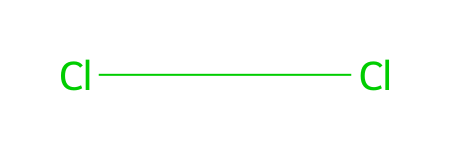

In [297]:
mol

In [298]:
class MolecularIsotope():
  """Store a molecule's isotopic properties."""
  def __init__(
      self,
      sml: str,
      abundance: float = None):
    self.sml = sml
    self.abundance = abundance
    try:
      self.mol = Chem.AddHs(Chem.MolFromSmiles(sml))
    except:
      self.mol = Chem.AddHs(Chem.MolFromSmiles(sml, sanitize=False))
    self.mass = Descriptors.ExactMolWt(self.mol)
  def update(self):
    self.mass = Descriptors.ExactMolWt(self.mol)
    self.canon_sml = Chem.MolToSmiles(mol)

In [299]:
from mendeleev import isotope, element
def element_set(molecule):
    """Get the set of elements in an RDKit molecule
    For example, ethanol (SMILES CCO, formula C2H5OH)
    returns {'C', 'O', 'H'}.

    :param molecule: The molecule to analyze
    :type some_input: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    if molecule:
      # Add hydrogen atoms--RDKit excludes them by default
      molecule_with_Hs = Chem.AddHs(molecule)
      atom_symbols = set(atom.GetSymbol() for atom in molecule_with_Hs.GetAtoms())
      return atom_symbols

In [300]:
set_of_elements = element_set(mol)
print(set_of_elements)
isotopes = {}
for element_symbol in set_of_elements:
  # print(f"{element=}")
  # print(f"{element(element)=}")
  element_isotopes = element(element_symbol).isotopes
  occuring_isotopes = [[isotope.mass_number, isotope.abundance/100] for isotope in element_isotopes if isotope.abundance != None]
  isotopes[element_symbol] = occuring_isotopes
print(isotopes)

{'Cl'}
{'Cl': [[35, 0.758], [37, 0.242]]}


In [301]:
num_atoms = len(mol.GetAtoms())

# Build iterable of number of isotopes by atom index
isotopes_by_atom_index = ()
for atom_index, atom in enumerate(mol.GetAtoms()):
  atom_symbol = atom.GetSymbol()
  isotopes_by_atom_index += (len(isotopes[atom_symbol]),)

In [302]:
print(num_atoms)
print(len(isotopes_by_atom_index))
assert num_atoms == len(isotopes_by_atom_index)
print(isotopes_by_atom_index)

2
2
(2, 2)


In [303]:
def set_isotopes(arr:np.ndarray, sml: str, current_index=()):
    if isinstance(arr, np.ndarray):
        for i in range(len(arr)):
            arr[i] = set_isotopes(arr=arr[i], current_index=current_index + (i,), sml=sml)
        return arr
    else:
        # For an individual item in the ndarray, create molecule, 
        # set the isotopes of each of its atoms, and calculate abundance
        item = MolecularIsotope(sml=sml)
        mol = item.mol
        abundance = 1
        for atom_index, atom in enumerate(mol.GetAtoms()):
          atom_symbol = atom.GetSymbol()
          isotope_data_to_use = isotopes[atom_symbol][current_index[atom_index]]
          isotope_to_use = isotope_data_to_use[0]
          atom.SetIsotope(isotope_to_use)
          abundance *= isotope_data_to_use[1]
        item.update()
        item.abundance = abundance          
        return item

In [304]:
# Create the empty numpy ndarray with the specified shape
mol_isotopes = np.empty(isotopes_by_atom_index, dtype=object)

# Set the isotopes for each atom in each molecule
mol_isotopes = set_isotopes(arr = mol_isotopes, sml = sml, current_index=())

In [305]:
def composition(
        molecule,
        isotopes=False):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, fluoride ion (chemical formula F-, SMILES string [F-])
    returns {9: 1, 0: -1}.

    :param molecule: The molecule to analyze
    :type some_input: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    if molecule:

        # Add hydrogen atoms--RDKit excludes them by default
        Chem.AddHs(molecule)
        comp = defaultdict(lambda: 0)

        # Get atom counts
        for atom in molecule.GetAtoms():
            element = atom.GetSymbol()
            if not isotopes:
                comp[element] += 1
            else:
                isotope = atom.GetIsotope()
                comp[element] = defaultdict(lambda: 0)
                comp[element][isotope] += 1
        return comp

In [306]:
def flatten_ndarray(arr):
    flat_list = []
    for element in arr:
        if isinstance(element, np.ndarray):
            flat_list.extend(flatten_ndarray(element))
        else:
            flat_list.append(element)
    return flat_list

In [307]:
def binomial_coefficient(n, k):
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))

In [308]:
def distribute_items(n, k):
    def backtrack(remaining_items, bins, current_bin):
        if current_bin == k:
            if remaining_items == 0:
                results.append(list(bins))
            return

        for items_in_current_bin in range(remaining_items + 1):
            bins[current_bin] = items_in_current_bin
            backtrack(remaining_items - items_in_current_bin, bins, current_bin + 1)

    results = []
    bins = [0] * k
    backtrack(n, bins, 0)
    return results

In [309]:
mol_isotopes_flat = flatten_ndarray(mol_isotopes)
mol_isotopes_flat.sort(key=lambda x:x.mass)

In [310]:
print(composition(mol_isotopes_flat[0].mol, isotopes=True))

defaultdict(<function composition.<locals>.<lambda> at 0x17ca6e5c0>, {'Cl': defaultdict(<function composition.<locals>.<lambda> at 0x17ca6e480>, {35: 1})})


In [311]:
# Function to flatten nested defaultdict into a flat dictionary
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [312]:
nested_dict = composition(mol_isotopes_flat[0].mol, isotopes=True)
flat_dict = flatten_dict(nested_dict)
flat_dict

{'Cl_35': 1}

In [350]:
import polars as pl
data_dict_list = []
for mol_isotope in mol_isotopes_flat:
    data_dict = {prop: getattr(mol_isotope, prop) for prop in vars(mol_isotope).keys()}
    data_dict["mol_isotope"] = mol_isotope
    flat_composition = flatten_dict(composition(mol_isotope.mol, isotopes=True))
    data_dict["composition"] = flat_composition
    # data_dict["composition"] = str(composition(mol_isotope.mol, isotopes=True))
    data_dict_list.append(data_dict)
df = pl.DataFrame(data_dict_list)

# data_dict_list_composition = []
# for mol_isotope in mol_isotopes_flat:
#     flat_dict = flatten_dict(nested_dict)
#     data_dict_composition = {"composition": flat_dict}
#     # data_dict_list_composition.append(data_dict)
# df_composition = pl.DataFrame(data_dict_composition.items(), schema=["key", "value"])

# df = df.with_columns(df_composition)
df

sml,abundance,mol,mass,canon_sml,mol_isotope,composition
str,f64,object,f64,str,object,struct[2]
"""ClCl""",0.574564,<rdkit.Chem.rdchem.Mol object at 0x16d4fe650>,69.937705,"""ClCl""",<__main__.MolecularIsotope object at 0x17c95e550>,"{1,null}"
"""ClCl""",0.183436,<rdkit.Chem.rdchem.Mol object at 0x16d4fcf20>,71.934755,"""ClCl""",<__main__.MolecularIsotope object at 0x16c915c50>,"{null,1}"
"""ClCl""",0.183436,<rdkit.Chem.rdchem.Mol object at 0x17cabcf90>,71.934755,"""ClCl""",<__main__.MolecularIsotope object at 0x17ca1a7d0>,"{1,null}"
"""ClCl""",0.058564,<rdkit.Chem.rdchem.Mol object at 0x17cabd150>,73.931805,"""ClCl""",<__main__.MolecularIsotope object at 0x17ca52410>,"{null,1}"


In [351]:
for index, row in enumerate(df.iter_rows()):
    print(row)
    # composition_value = row['composition']
    # print(f"Row {index}: Composition = {composition_value}")


('ClCl', 0.574564, <rdkit.Chem.rdchem.Mol object at 0x16d4fe650>, 69.93770536, 'ClCl', <__main__.MolecularIsotope object at 0x17c95e550>, {'Cl_35': 1, 'Cl_37': None})
('ClCl', 0.183436, <rdkit.Chem.rdchem.Mol object at 0x16d4fcf20>, 71.93475527, 'ClCl', <__main__.MolecularIsotope object at 0x16c915c50>, {'Cl_35': None, 'Cl_37': 1})
('ClCl', 0.183436, <rdkit.Chem.rdchem.Mol object at 0x17cabcf90>, 71.93475527, 'ClCl', <__main__.MolecularIsotope object at 0x17ca1a7d0>, {'Cl_35': 1, 'Cl_37': None})
('ClCl', 0.058564, <rdkit.Chem.rdchem.Mol object at 0x17cabd150>, 73.93180518, 'ClCl', <__main__.MolecularIsotope object at 0x17ca52410>, {'Cl_35': None, 'Cl_37': 1})


In [352]:
first_composition = str(df['composition'][0])
first_composition

"{'Cl_35': 1, 'Cl_37': None}"

In [353]:
agg_exprs = [
    pl.sum("abundance").alias("abundance")
] + [
    pl.col(col).first().alias(col)
    for col in df.columns
    if col not in ("composition", "abundance")
    # if col not in ("abundance")
]
for agg in agg_exprs:
    print(agg)
result_df = df.group_by("composition").agg(agg_exprs)
result_df

col("abundance").sum().alias("abundance")
col("sml").first().alias("sml")
col("mol").first().alias("mol")
col("mass").first().alias("mass")
col("canon_sml").first().alias("canon_sml")
col("mol_isotope").first().alias("mol_isotope")


composition,abundance,sml,mol,mass,canon_sml,mol_isotope
struct[2],f64,str,object,f64,str,object
"{null,1}",0.242,"""ClCl""",<rdkit.Chem.rdchem.Mol object at 0x16d4fcf20>,71.934755,"""ClCl""",<__main__.MolecularIsotope object at 0x16c915c50>
"{1,null}",0.758,"""ClCl""",<rdkit.Chem.rdchem.Mol object at 0x16d4fe650>,69.937705,"""ClCl""",<__main__.MolecularIsotope object at 0x17c95e550>


In [315]:
for mol_isotope in mol_isotopes_flat[:10]:
    print(mol_isotope.mass)

69.93770536
71.93475527
71.93475527
73.93180518


In [316]:
for atom in mol_isotopes_flat[0].mol.GetAtoms():
    print(f"{atom.GetIsotope()}{atom.GetSymbol()}")

35Cl
35Cl


In [317]:
composition(mol_isotopes_flat[0].mol, isotopes=True)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'Cl': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {35: 1})})

In [318]:
mols_flat = [mol_isotope.mol for mol_isotope in mol_isotopes_flat]
abundance_flat = [mol_isotope.abundance for mol_isotope in mol_isotopes_flat]
mass_flat = [mol_isotope.mass for mol_isotope in mol_isotopes_flat]
legends = [f"{mass:.3f}: {abundance:.3f}" for mass, abundance in zip(mass_flat, abundance_flat)]
abundance_sum = sum(abundance_flat)
# Chem.Draw.MolsToGridImage(mols = mols_flat, legends = legends, molsPerRow=3)
print(len(mols_flat))

a = composition(mol_isotopes_flat[0].mol, isotopes=True)
b = composition(mol_isotopes_flat[0].mol, isotopes=True)
print(a)
print(b)
print(a == b)
print(a is b)

4
defaultdict(<function composition.<locals>.<lambda> at 0x16ccde2a0>, {'Cl': defaultdict(<function composition.<locals>.<lambda> at 0x17ca6c720>, {35: 1})})
defaultdict(<function composition.<locals>.<lambda> at 0x16d6c8220>, {'Cl': defaultdict(<function composition.<locals>.<lambda> at 0x16d6ca520>, {35: 1})})
True
False


It might be tempting to match molecules by mass, but a floating-point value can have some error or uncertainty. In some cases, the mass differences between different species can be quite small (for example less than 0.002 amu if the sum of the mass numbers is the same), so adding a tolerance risks lumping different molecules together. So it's best to use some discrete identifier. In this case, we use the SMILES, which contains isotope labels.

In [319]:
# Merge identical molecules
merged_molecular_isotpes = [mol_isotopes_flat[0]]
# print(composition(mol_isotopes_flat[0].mol, isotopes=True))
for molecular_isotope in mol_isotopes_flat[1:]:
  last_merged = merged_molecular_isotpes[-1]
  # print(composition(molecular_isotope.mol, isotopes=True))
  # if Chem.MolToSmiles(molecular_isotope.mol) == Chem.MolToSmiles(last_merged.mol):
  if composition(molecular_isotope.mol, isotopes=True) == composition(last_merged.mol, isotopes=True):
    last_merged.abundance += molecular_isotope.abundance
    # print("  was merged")
  else:
    merged_molecular_isotpes.append(molecular_isotope)
    # print("  was not merged")

In [320]:
mols_merged_flat = [mol_isotope.mol for mol_isotope in merged_molecular_isotpes]
abundance_merged_flat = [mol_isotope.abundance for mol_isotope in merged_molecular_isotpes]
mass_merged_flat = [mol_isotope.mass for mol_isotope in merged_molecular_isotpes]
legends = [f"{mass:.9f}: {abundance:.3f}" for mass, abundance in zip(mass_merged_flat, abundance_merged_flat)]

print(len(mols_merged_flat))

4


In [321]:
for legend in legends:
  print(legend)

69.937705360: 0.575
71.934755270: 0.183
71.934755270: 0.183
73.931805180: 0.059


In [322]:
# Print masses and differences between adjacent molecules
for index, mass in enumerate(mass_merged_flat):
  if all([index > 0, index < len(mass_merged_flat) - 1]):
    print(f"{index:<4} {mass:<25} {mass_merged_flat[index-1]:<25} {mass - mass_merged_flat[index-1]}")

1    71.93475527               69.93770536               1.9970499100000012
2    71.93475527               71.93475527               0.0


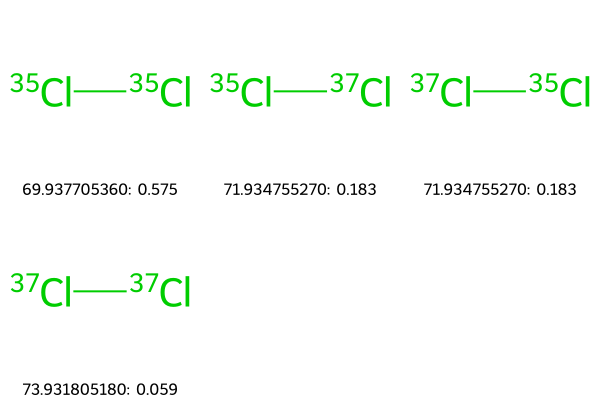

In [323]:
Chem.Draw.MolsToGridImage(mols = mols_merged_flat, legends = legends)

In [324]:
abundance_sum = sum(abundance_merged_flat)
print(abundance_sum)

0.9999999999999999


In [325]:
df = pd.DataFrame({
    'Mass': mass_merged_flat,
    'Abundance': abundance_merged_flat
})

In [326]:
df = df.loc[df['Abundance'] >= 0.01]

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


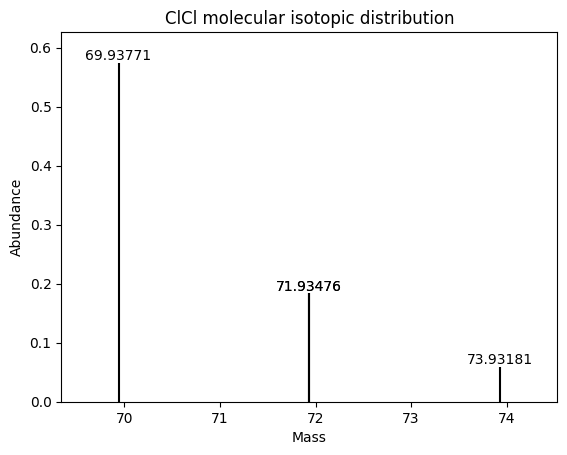

In [327]:
# Create the scatter plot using Seaborn
sns.scatterplot(x='Mass', y='Abundance', data=df, marker='')

plt.xlabel('Mass')
plt.ylabel('Abundance')
plt.title(f'{sml} molecular isotopic distribution')

# Adjust x-axis limits to allow more space on the left and right for labels
xrange = max(df['Mass']) - min(df['Mass'])
xpad = xrange * 0.15
plt.xlim(min(df['Mass']) - xpad, max(df['Mass']) + xpad)

# Adjust y-axis limits to start at zero and allow more space on the top for labels
yrange = max(df['Abundance']) - min(df['Abundance'])
ypad = yrange * 0.1
plt.ylim(0, max(df['Abundance']) + ypad)

# Add vertical lines from each data point to the x-axis
for x, y in zip(df['Mass'], df['Abundance']):
    plt.vlines(x=x, ymin=0, ymax=y, colors='black')
    # Label the data points by mass
    plt.text(x=x, y=y, s=f'{x:.5f}', ha='center', va='bottom')

plt.show()

In [328]:
mol = Chem.MolFromSmiles(sml)

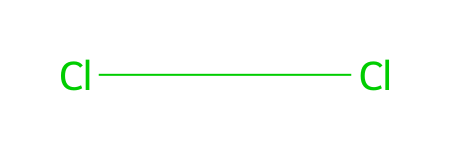

In [329]:
mol

In [330]:
#Debugging only!
# isotopes = {'Cl': [[35, 0.5], [37, 0.5]]}
# isotopes = {'O': [[16, 0.5], [17, 0.5]]}

# Create a list to store the dimensions at each step
dimensions = []

mols:np.ndarray = np.array(Chem.Mol(mol))
# print(f"{type(mols)=}")
# print(f"Start: {mols=}")
for this_element, n_this_element in composition(mol).items():
  print("--------------------------------")
  print(this_element, n_this_element)
  print("--------------------------------")
  #Debugging
  if this_element == "N":
    pass
  n_isotopes_this_element = len(isotopes[this_element])
  isotope_count_distribution = distribute_items(n_this_element, n_isotopes_this_element)
  n_distributions = len(isotope_count_distribution)
  print(f"{isotope_count_distribution=}")

  print(f"Before adding a dimension: {mols.shape=}")
  
  if mols.shape == ():
     mols = np.array([Chem.Mol(mol) for _ in range(n_distributions)], dtype=object)
     print(f"{type(mols)=}")
  else:
    # Create a list of m copies of the current object
    mols_list = [copy.deepcopy(mols) for _ in range(n_distributions)]
    
    # Convert the list of copies to a NumPy ndarray
    mols = np.array(mols_list, dtype=object)

    print(f"{type(mols)=}")
    

  print(f"{mols=}")
  print(f"{n_this_element=}")

  sum_ab = 0
  masses = []
  for distribution_index, distribution in enumerate(isotope_count_distribution):
      print(distribution)
      a = 1
      b = binomial_coefficient(n_this_element, distribution[0])
      for isotope_index, isotope_count in enumerate(distribution):
        a_this_isotope = isotopes[this_element][isotope_index][1]
        a *= a_this_isotope**isotope_count
      ab = a*b
      sum_ab += ab
      # print(f"{a=} {b=} {a*b=} {sum_ab=}")
  for item_index, item in enumerate(mols):
    level = 0
    if isinstance(item, np.ndarray):
      while isinstance(item, np.ndarray):
        level += 1
        parent_index = item_index
        for item_index, item in enumerate(item):
            print(f"{level=} {item_index=}, {item=}, is ndarray={isinstance(item, np.ndarray)}")
            if isinstance(item, np.ndarray):
              break
            else:
              print(f"    {item=}, should be a mol")
              distribution_countdown = isotope_count_distribution[parent_index].copy()
              print(f"  initial {distribution_countdown=}")
              
              for atom_index, atom in enumerate(item.GetAtoms()):
                if atom.GetSymbol() == this_element:
                  # Count down each isotope, going on to the next when zero
                  for isotope_index, isotope in enumerate(distribution):
                    print(f"    {isotope_index=}")
                    if distribution_countdown[isotope_index] > 0:
                        print(f"      {isotopes[this_element][isotope_index][0]=}")
                        atom.SetIsotope(isotopes[this_element][isotope_index][0])
                        distribution_countdown[isotope_index] -= 1
                        print(f"      {distribution_countdown=}")
                    # else:
                        break
    else:
      distribution_countdown = isotope_count_distribution[item_index].copy()
      for atom_index, atom in enumerate(item.GetAtoms()):
        if atom.GetSymbol() == this_element:
          # Count down each isotope, going on to the next when zero
          for isotope_index, isotope in enumerate(distribution):
            print(f"    {isotope_index=}")
            if distribution_countdown[isotope_index] > 0:
                print(f"      {isotopes[this_element][isotope_index][0]=}")
                atom.SetIsotope(isotopes[this_element][isotope_index][0])
                distribution_countdown[isotope_index] -= 1
                print(f"      {distribution_countdown=}")
            # else:
                break

            # for atom_index, atom in enumerate(item.GetAtoms()):
            #   print(f"{atom_index}, {atom.GetSymbol()}, {atom.GetIsotope()}")


      # # Current row of molecules
      # if mols.ndim > 1:
      #   this_row = mols[distribution_index]
      # else:
      #   this_row = mols
      # print(f"{this_row=}")
  
  # pass
print(f"{sum_ab=}")
print(f"{mols=}")
print(f"{type(mols)=}")


--------------------------------
Cl 2
--------------------------------
isotope_count_distribution=[[0, 2], [1, 1], [2, 0]]
Before adding a dimension: mols.shape=()
type(mols)=<class 'numpy.ndarray'>
mols=array([<rdkit.Chem.rdchem.Mol object at 0x16b91bfb0>,
       <rdkit.Chem.rdchem.Mol object at 0x16b7b82c0>], dtype=object)
n_this_element=2
[0, 2]
[1, 1]
[2, 0]
    isotope_index=0
    isotope_index=1
      isotopes[this_element][isotope_index][0]=37
      distribution_countdown=[0, 1]
    isotope_index=0
    isotope_index=1
      isotopes[this_element][isotope_index][0]=37
      distribution_countdown=[0, 0]
    isotope_index=0
      isotopes[this_element][isotope_index][0]=35
      distribution_countdown=[0, 1]
    isotope_index=0
    isotope_index=1
      isotopes[this_element][isotope_index][0]=37
      distribution_countdown=[0, 0]
    isotope_index=0
      isotopes[this_element][isotope_index][0]=35
      distribution_countdown=[1, 0]
    isotope_index=0
      isotopes[this_eleme

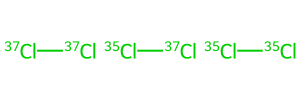

In [331]:
# Chem.Draw.MolsToGridImage(mols, legends=[str(mass) for mass in masses])

mols_flat = flatten_ndarray(mols)

Chem.Draw.MolsToGridImage(mols_flat, subImgSize=(100, 100)) #, legends=[str(mass) for mass in masses])

Divider

In [332]:
# #Debugging only!
# # isotopes = {'Cl': [[35, 0.5], [37, 0.5]]}

# n_atoms = 2

# n_enumerated = 0
# # n_test_atoms = 4
# # for isotope_count in range(n_test_atoms + 1):
# for isotope_count in range(n_atoms + 1):
#     n_enumerated += binomial_coefficient(n_atoms, isotope_count)

# print(f"{n_enumerated=}")

# #Debugging only!
# # n_atoms = 3

# sum_ab = 0
# for isotope_count in range(n_atoms + 1):
#   # for isotope in isotopes["Cl"]:
#     n_this_isotope = isotope_count
#     mass_this_isotope = isotopes["Cl"][0][0]
#     n_other_isotope = n_atoms - isotope_count
#     mass_other_isotope = isotopes["Cl"][1][0]
#     a_this_isotope = isotopes["Cl"][0][1]
#     a_other_isotope = isotopes["Cl"][1][1]
#     b = binomial_coefficient(n_atoms, n_this_isotope)
#     a_from_this_isotope = (a_this_isotope**n_this_isotope)
#     a_from_other_isotope = (a_other_isotope**n_other_isotope)
#     # print(f"this isotope : {n_this_isotope} {mass_this_isotope} {a_this_isotope} {a_this_isotope**n_this_isotope} {binomial_coefficient(n_atoms, n_this_isotope)} {a_from_this_isotope}")
#     # print(f"other isotope: {n_other_isotope} {mass_other_isotope} {a_other_isotope} {a_other_isotope**n_other_isotope} {binomial_coefficient(n_atoms, n_other_isotope)} {a_from_other_isotope}")
#     headers = "n          Mass     A      Result       Frac A_from"

#     # Define the data for the first isotope
#     data1 = f"{n_this_isotope:<12} {mass_this_isotope:<6} {a_this_isotope:<6} {a_this_isotope**n_this_isotope:<12} {a_from_this_isotope}"

#     # Define the data for the other isotope
#     data2 = f"{n_other_isotope:<12} {mass_other_isotope:<6} {a_other_isotope:<6} {a_other_isotope**n_other_isotope:<12} {a_from_other_isotope}"

#     print(headers)
#     print(data1)
#     print(data2)

#     a = a_from_this_isotope * a_from_other_isotope
#     print(f"{a=} {b=} {a*b=}")
#     sum_ab += a*b
# print(f"{sum_ab=}")
#     # print(isotope)

In [333]:
sml_check = "C#C"
mol_check = Chem.MolFromSmiles(sml_check)
for atom_index, atom in enumerate(mol_check.GetAtoms()):
    print(f"{atom_index}, {atom.GetSymbol()}, {atom.GetIsotope()}")

0, C, 0
1, C, 0


In [334]:
for element, count in composition(mol).items():
    abundance = isotopic_abundances[element]
    contribution *= pow(abundance, count)
    contribution *= binomial_coefficient(molecular_formula[element_symbol], count)
return contribution


NameError: name 'isotopic_abundances' is not defined